In [103]:
from cfl.experiment import Experiment
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from cfl_helpers import *

In [104]:
resolution = '40km'
n_clusters = 10
train_file = f'data/{resolution}_data.csv'
truth_file = f'data/{resolution}_truth.csv'

train_data = pd.read_csv(train_file)
Xraw = np.array(train_data[['lat', 'long']])
Yraw = np.array(train_data['generated_temp']).reshape(-1,1)
X = StandardScaler().fit_transform(Xraw)
Y = StandardScaler().fit_transform(Yraw)
print(Xraw.shape, Yraw.shape)

truth = pd.read_csv(truth_file)

(833, 2) (833, 1)


In [105]:
data_info = {'X_dims' : X.shape,
             'Y_dims' : Y.shape,
             'Y_type' : 'continuous'
            }

CDE_params = {  'model'        : 'CondExpMod',
                'model_params' : {
                    # model architecture
                    'dense_units' : [50, data_info['Y_dims'][1]],
                    'activations' : ['relu', 'linear'],
                    'dropouts'    : [0, 0],
                    # training parameters
                    'batch_size'  : 64,
                    'n_epochs'    : 3000,
                    'optimizer'   : 'adam',
                    'opt_config'  : {'lr' : 1e-4},
                    'loss'        : 'mean_squared_error',
                    'best'        : True,
                    'early_stopping' : True,
                    # verbosity
                    'verbose'     : 1, 
                    'show_plot'   : True,
                }
}

cause_cluster_params =  {'model' : 'KMeans',
                        'model_params' : {'n_clusters' : n_clusters},
                        'verbose' : 0
}

In [106]:
# block_names indicates which CDE and clustering models to use
block_names = ['CondDensityEstimator', 'CauseClusterer']

# block_params is aligned to block_names
block_params = [CDE_params, cause_cluster_params]

results_path = 'running1' # directory to save results to

# Create a new CFL experiment with specified parameters
my_exp = Experiment(X_train=X,
                    Y_train=Y,
                    data_info=data_info,
                    block_names=block_names,
                    block_params=block_params,
                    results_path=results_path)

All results from this run will be saved to running1/experiment0008
Block: verbose not specified in input, defaulting to 1
CondExpBase: activity_regularizers not specified in input, defaulting to None
CondExpBase: kernel_regularizers not specified in input, defaulting to None
CondExpBase: bias_regularizers not specified in input, defaulting to None
CondExpBase: kernel_initializers not specified in input, defaulting to None
CondExpBase: bias_initializers not specified in input, defaulting to None
CondExpBase: weights_path not specified in input, defaulting to None
CondExpBase: tb_path not specified in input, defaulting to None
CondExpBase: optuna_callback not specified in input, defaulting to None
CondExpBase: optuna_trial not specified in input, defaulting to None
CondExpBase: checkpoint_name not specified in input, defaulting to tmp_checkpoints


#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
No GPU device detected.
Epoch 1/3000
10/10 [==============================] - 0s 18ms/step - loss: 1.1974 - val_loss: 0.9244
Epoch 2/3000
10/10 [==============================] - 0s 10ms/step - loss: 1.1876 - val_loss: 0.9180
Epoch 3/3000
10/10 [==============================] - 0s 8ms/step - loss: 1.1789 - val_loss: 0.9116
Epoch 4/3000
10/10 [==============================] - 0s 6ms/step - loss: 1.1695 - val_loss: 0.9060
Epoch 5/3000
10/10 [==============================] - 0s 5ms/step - loss: 1.1618 - val_loss: 0.9006
Epoch 6/3000
10/10 [==============================] - 0s 5ms/step - loss: 1.1537 - val_loss: 0.8957
Epoch 7/3000
10/10 [==============================] - 0s 6ms/step - loss: 1.1464 - val_loss: 0.8912
Epoch 8/3000
10/10 [==============================] - 0s 5ms/step - loss: 1.1396 - val_loss: 0.8868
Epoch 9/3000
10/10 [==============================] - 

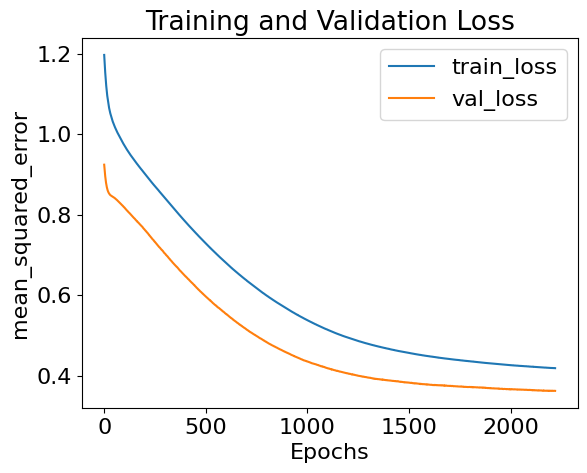

27/27 [==============================] - 0s 731us/step
Loading parameters from  tmp_checkpoints03022025011359/best_weights
Saving parameters to  running1/experiment0008/trained_blocks/CondDensityEstimator
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


In [107]:
results = my_exp.train()

<Figure size 1200x600 with 0 Axes>

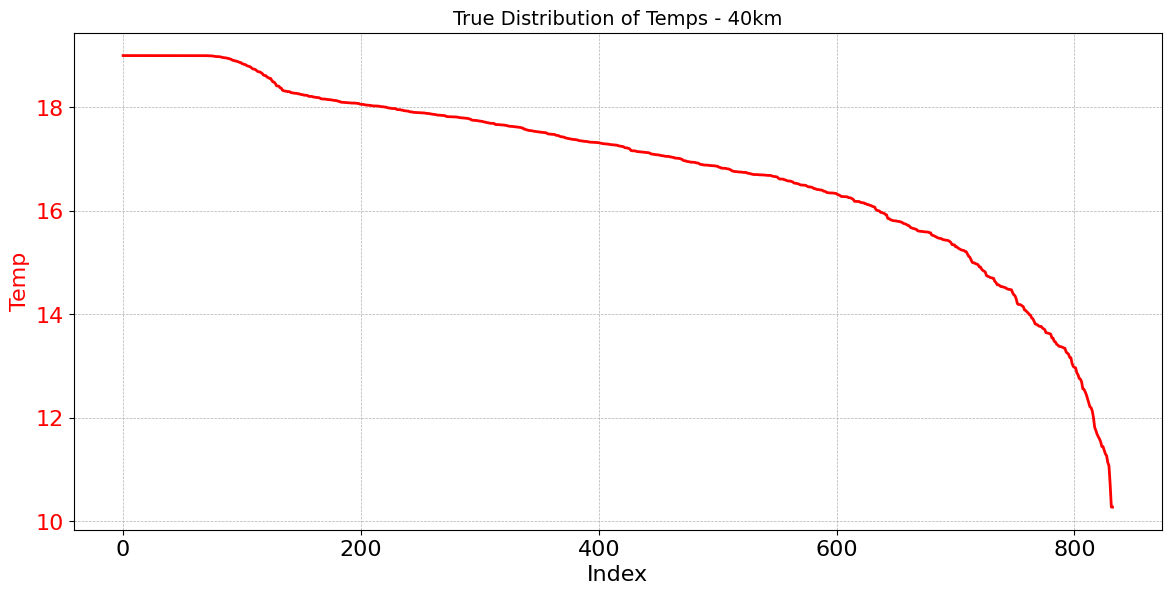

In [108]:
import matplotlib.pyplot as plt

# get true distribution of temperature

true_temps = truth['generated_temp']
sorted_idxs = true_temps.sort_values(ascending=False).index # to use later on
true_temps = true_temps[sorted_idxs]

plt.figure(figsize=(12, 6))
fig, ax1 = plt.subplots(figsize=(12, 6))

line_color = 'red'
ax1.set_xlabel('Index')
ax1.set_ylabel('Temp', color=line_color)
ax1.plot([x for x in range(len(true_temps))], true_temps, color=line_color, linewidth=2)
ax1.tick_params(axis='y', labelcolor=line_color)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ymin, ymax = ax1.get_ylim()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f'True Distribution of Temps - {resolution}', fontsize=14)
plt.show()

[(3, 18.98092788937749), (7, 18.971455571412807), (8, 18.95508474744582), (2, 17.995142426127323), (9, 17.75755938100455), (0, 17.25402790546439), (5, 16.807697129866362), (6, 15.990712345455576), (1, 15.52643578022372), (4, 13.690071671398728)]
MIN TEMP FOR THIS DATASET: 10.310965024067402


<Figure size 1200x600 with 0 Axes>

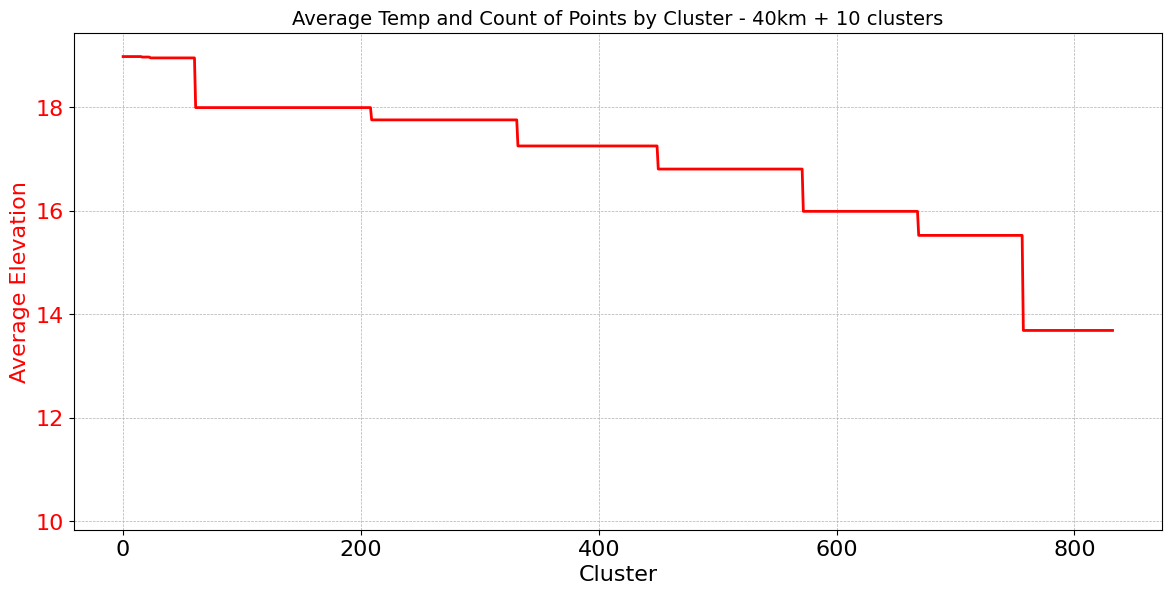

In [109]:
xlbls = results['CauseClusterer']['x_lbls']
len_data = len(train_data)

avgs, lbl_dict = get_group_avgs(train_data, xlbls)
avgs_list = [(key, avgs[key]) for key in avgs.keys()]
avgs_list = sorted(avgs_list, key=lambda x: x[1], reverse=True)

x_axis = np.linspace(0, len_data - 1, len_data)

print(avgs_list)

temp_preds = []
for clus, avg in avgs_list:
    for _ in range(len(lbl_dict[clus])):
        temp_preds.append(avg)
temp_preds = np.array(temp_preds).flatten()

plt.figure(figsize=(12, 6))
fig, ax1 = plt.subplots(figsize=(12, 6))

print(f'MIN TEMP FOR THIS DATASET: {train_data["generated_temp"].min()}')

line_color = 'red'
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Average Elevation', color=line_color)
ax1.plot(x_axis, temp_preds, color=line_color, linewidth=2)
ax1.tick_params(axis='y', labelcolor=line_color)
ax1.set_ylim(ymin, ymax)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f'Average Temp and Count of Points by Cluster - {resolution} + {n_clusters} clusters', fontsize=14)
plt.show()